## Notebook to combine drifts
(to be implemented in python module at later point)

In [4]:
# imports
from utils import helpers, constants
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# config
change_point_detector = 'emd'

# load data dictionary
data_dictionary = helpers.load_data_dictionary(constants.DATA_DICTIONARY_FILE_PATH)

In [8]:
from collections import defaultdict


window_sizes = [100, 200, 300, 400, 500, 600]

# Load all change points into a consistent dictionary of DataFrames
change_points_dict = {}

for dataset in data_dictionary:
    dataset_cps = defaultdict(list)  # maps window_size → list of change points

    for window_size in window_sizes:
        results_path = f'results/drift_detection/{dataset}/results_{dataset}_{change_point_detector}{window_size}.csv'

        if os.path.exists(results_path):
            results_df = pd.read_csv(results_path)

            for _, row in results_df.iterrows():
                if row.get('calc_drift_id') == 'na':
                    break

                change_point = row.get('calc_change_index')

                if pd.notna(change_point):
                    dataset_cps[window_size].append(int(change_point))

    # convert defaultdict to normal dict before storing
    change_points_dict[dataset] = dict(dataset_cps)

In [ ]:
import numpy as np
import pandas as pd

def aggregate_change_points_by_window(cp_all_window_sizes, alpha=1.0):
    """
    Aggregates change points across window sizes by merging close ones,
    preferring the closest match (not just the first found).

    Returns a DataFrame with cp, window_size, support.
    """
    if not cp_all_window_sizes:
        return pd.DataFrame(columns=["cp", "window_size", "support", "supporting_windows"])

    max_ws = max(cp_all_window_sizes.keys())

    # Step 1: Flatten and initialize support + support set
    records = []
    for ws, cp_list in cp_all_window_sizes.items():
        for cp in cp_list:
            support = np.log(ws) / np.log(max_ws)
            records.append({
                "cp": cp,
                "window_size": ws,
                "support": support,
                "supporting_windows": {ws}
            })

    # Sort by descending window size, then cp
    records.sort(key=lambda x: (-x["window_size"], x["cp"]))

    merged_records = []

    for i, rec_a in enumerate(records):
        candidates = []

        # Find merge candidates in smaller window sizes
        for j in range(i + 1, len(records)):
            rec_b = records[j]
            if rec_b["window_size"] >= rec_a["window_size"]:
                continue  # only merge into smaller window

            dist = abs(rec_a["cp"] - rec_b["cp"])
            if dist <= rec_a["window_size"] * alpha:
                candidates.append((dist, rec_b))

        # Choose the closest candidate (if any)
        if candidates:
            _, closest = min(candidates, key=lambda x: x[0])
            closest["support"] += rec_a["support"]
            closest["supporting_windows"] |= rec_a["supporting_windows"]
        else:
            merged_records.append(rec_a)

    return pd.DataFrame(merged_records)

# --- Outer filtering function --- #

def deduplicate_change_points_by_window(cp_all_window_sizes, alpha=1.0, min_required_windows=[100, 200]):
    """
    Deduplicate change points by support-based filtering on top of aggregation.

    Parameters
    ----------
    cp_em_all_window_sizes : dict
        Dictionary of form {window_size: [change_point_1, ...]}
    alpha : float
        Distance factor for merging similar change points
    min_required_windows : list of int
        List of window sizes required to support a change point

    Returns
    -------
    list of int
        Deduplicated and filtered list of change points
    """
    if not cp_all_window_sizes:
        return []


    # Aggregate and merge support
    aggregated_df = aggregate_change_points_by_window(cp_all_window_sizes, alpha)

    # handle no change point situations
    if aggregated_df.empty:
        return []

    # Compute threshold based on desired minimum window sizes
    max_ws = max(cp_all_window_sizes.keys())
    min_support = sum(np.log(ws) / np.log(max_ws) for ws in min_required_windows)

    # Filter
    filtered_df = aggregated_df[aggregated_df["support"] >= min_support]

    return list(filtered_df["cp"])


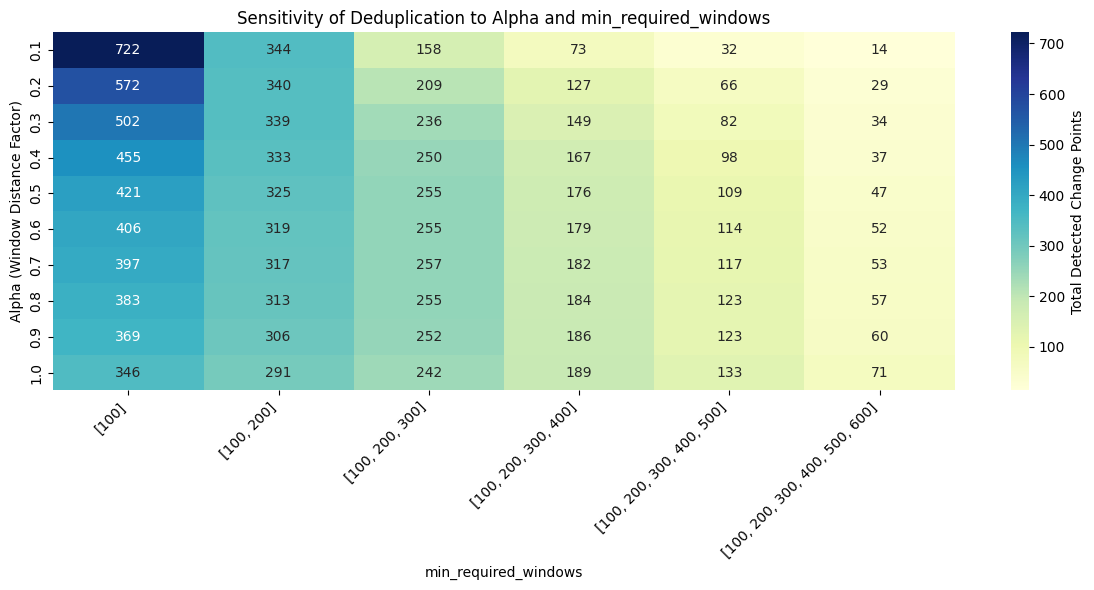

In [37]:
# check sensitivity of input parmeters

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define parameters
alphas = np.round(np.arange(0.1, 1.01, 0.1), 2)
window_sizes_full = [100, 200, 300, 400, 500, 600]
window_sets = [window_sizes_full[:i] for i in range(1, len(window_sizes_full)+1)]

# Optional: label each window set for x-axis
window_labels = [str(ws) for ws in window_sets]

# Initialize heatmap data: rows = alphas, columns = window_sets
heatmap_data = pd.DataFrame(index=alphas, columns=window_labels)

# Loop over all combinations
for alpha in alphas:
    for i, min_required_windows in enumerate(window_sets):
        label = window_labels[i]
        total_cps = 0

        for dataset, cp_all_window_sizes in change_points_dict.items():
            cps = deduplicate_change_points_by_window(
                cp_all_window_sizes,
                alpha=alpha,
                min_required_windows=min_required_windows
            )
            total_cps += len(cps)

        heatmap_data.at[alpha, label] = total_cps

# Convert to numeric for plotting
heatmap_data = heatmap_data.astype(int)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Total Detected Change Points'})
plt.title("Sensitivity of Deduplication to Alpha and min_required_windows")
plt.xlabel("min_required_windows")
plt.ylabel("Alpha (Window Distance Factor)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [38]:
# 1. Aggregate all datasets (returns DataFrames)
aggregated_cp_dict = {
    dataset: aggregate_change_points_by_window(cp_all_window_sizes, alpha=0.5)
    for dataset, cp_all_window_sizes in change_points_dict.items()
}

# 2. Deduplicate all datasets (returns lists of CPs)
deduplicated_cp_dict = {
    dataset: deduplicate_change_points_by_window(cp_all_window_sizes, alpha=0.5, min_required_windows=[100, 200, 300])
    for dataset, cp_all_window_sizes in change_points_dict.items()
}

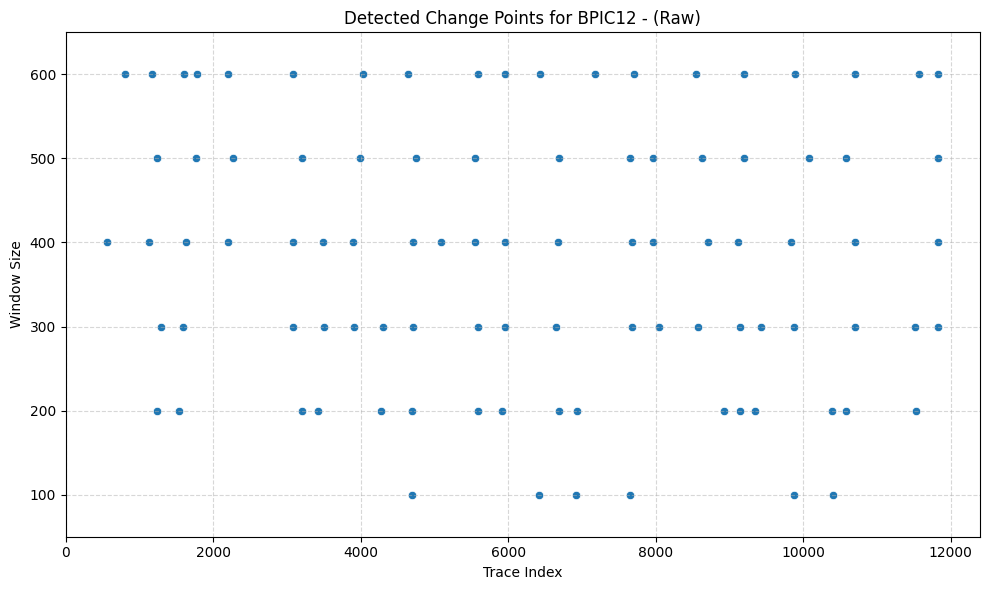

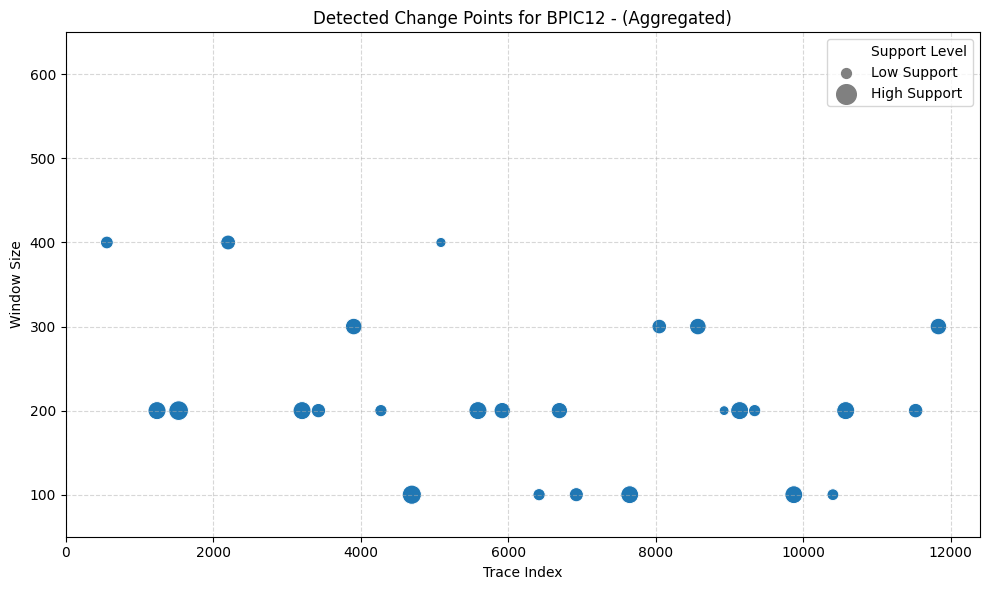

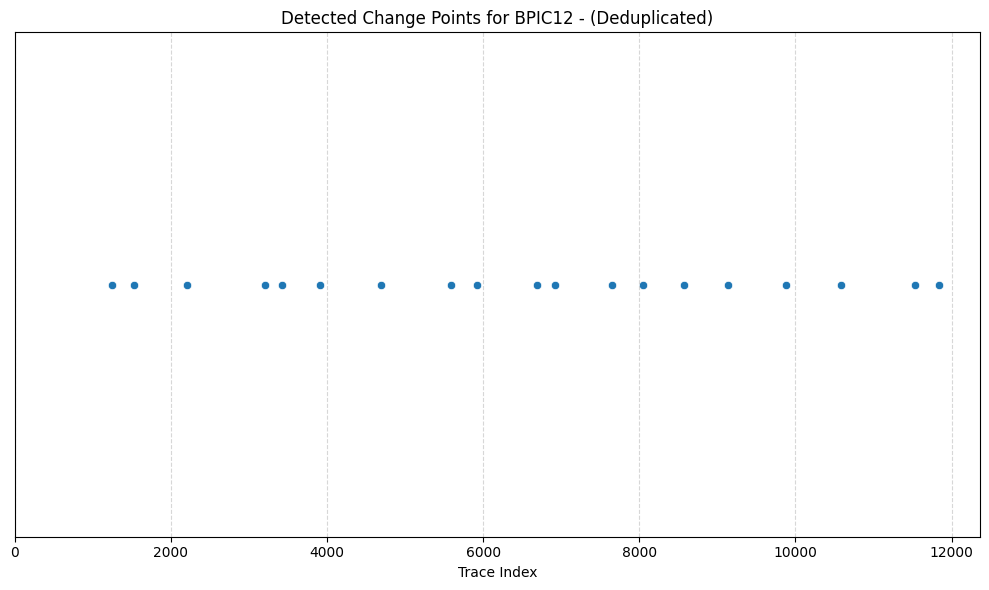

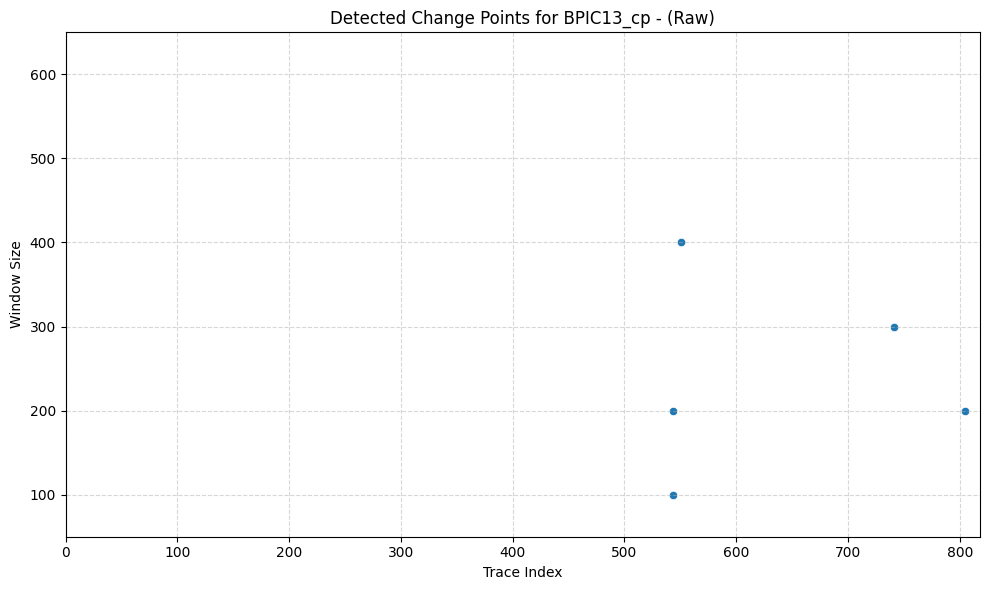

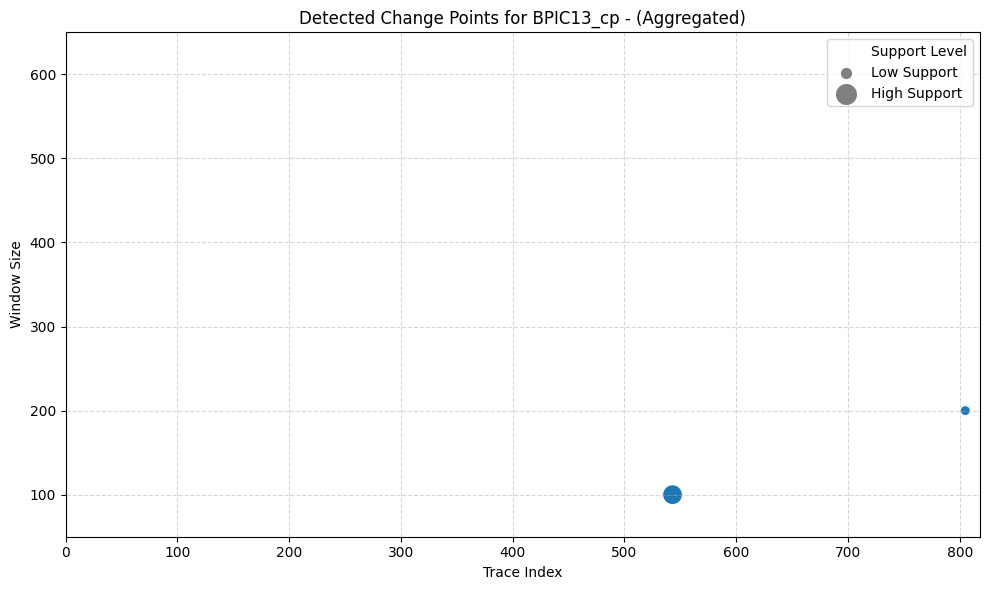

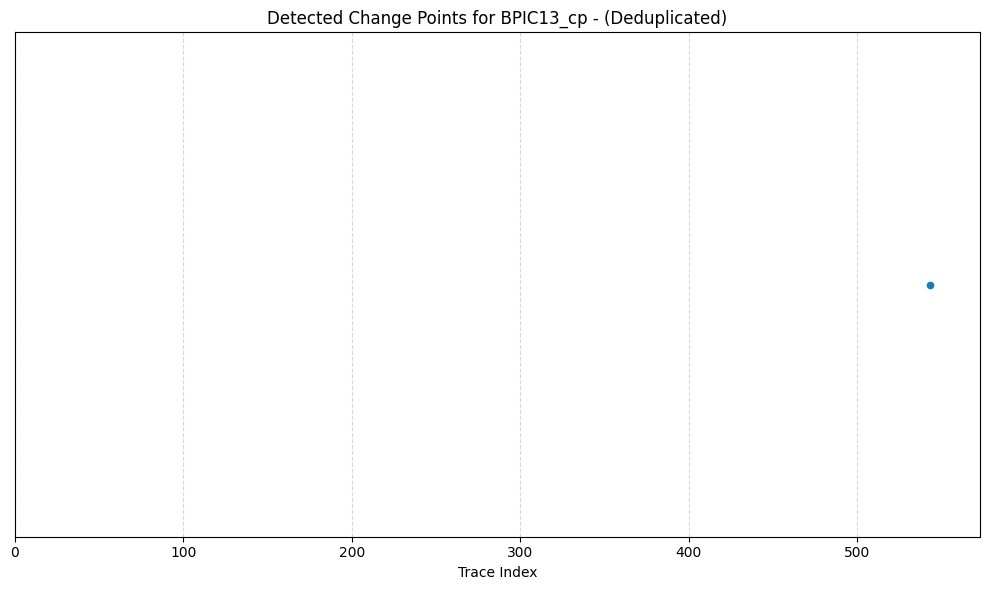

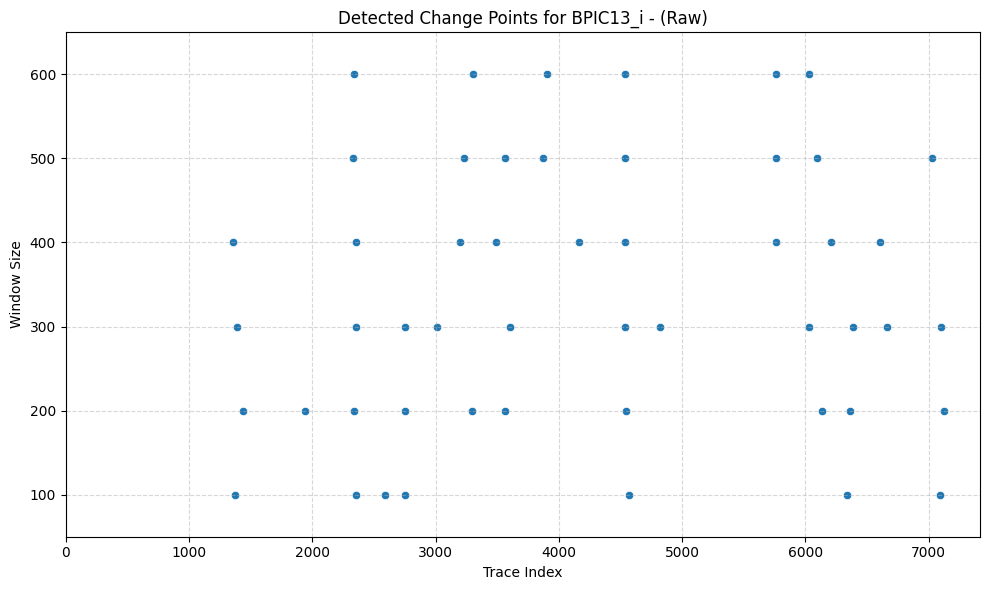

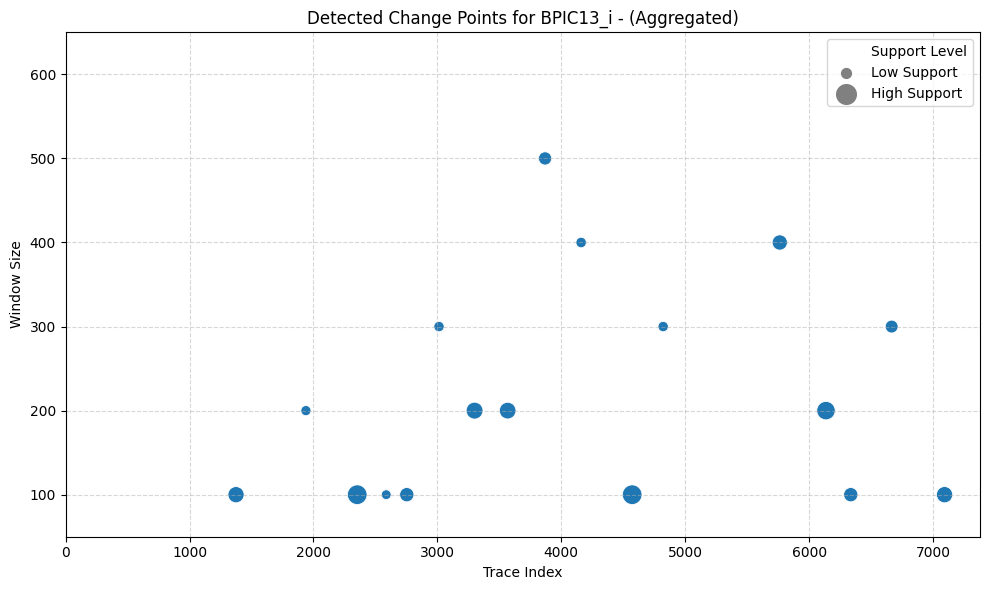

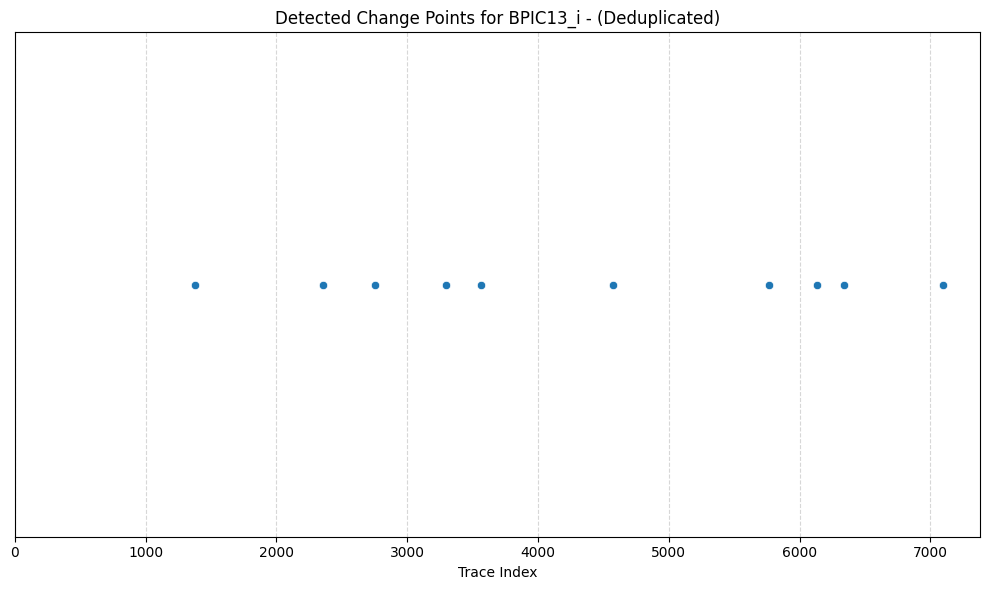

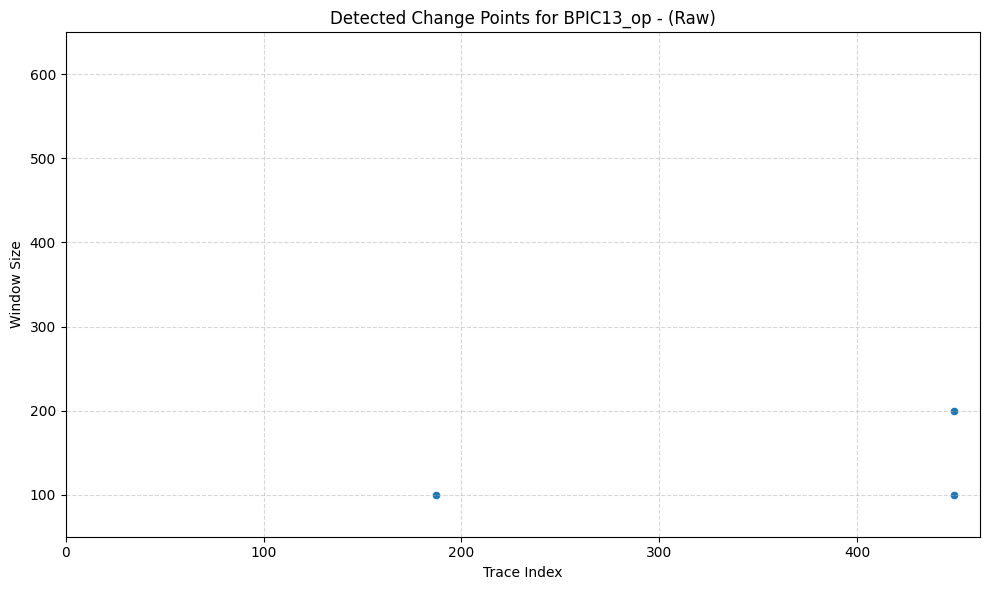

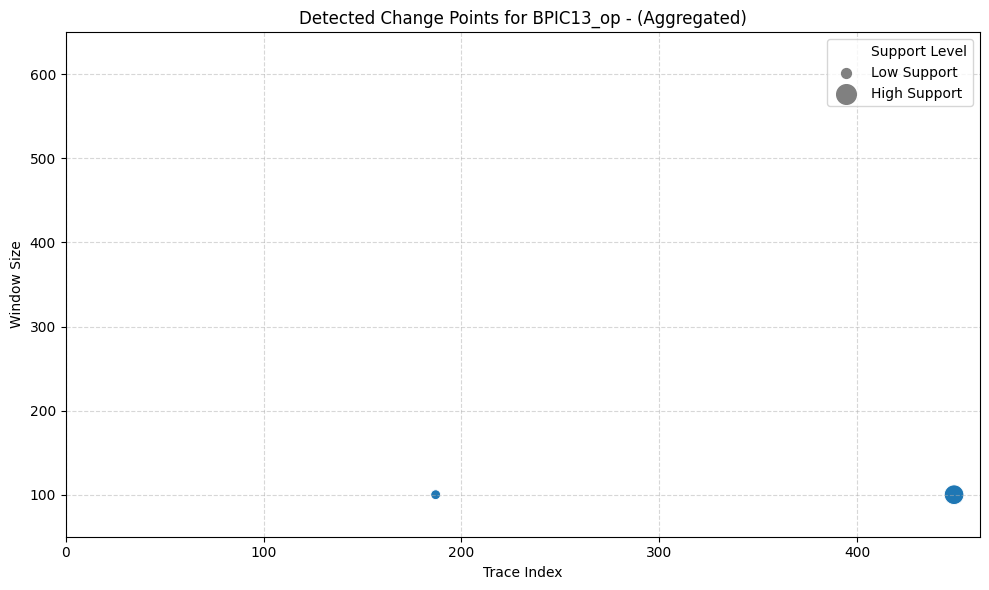

[INFO] No change points to plot for dataset BPIC13_op.


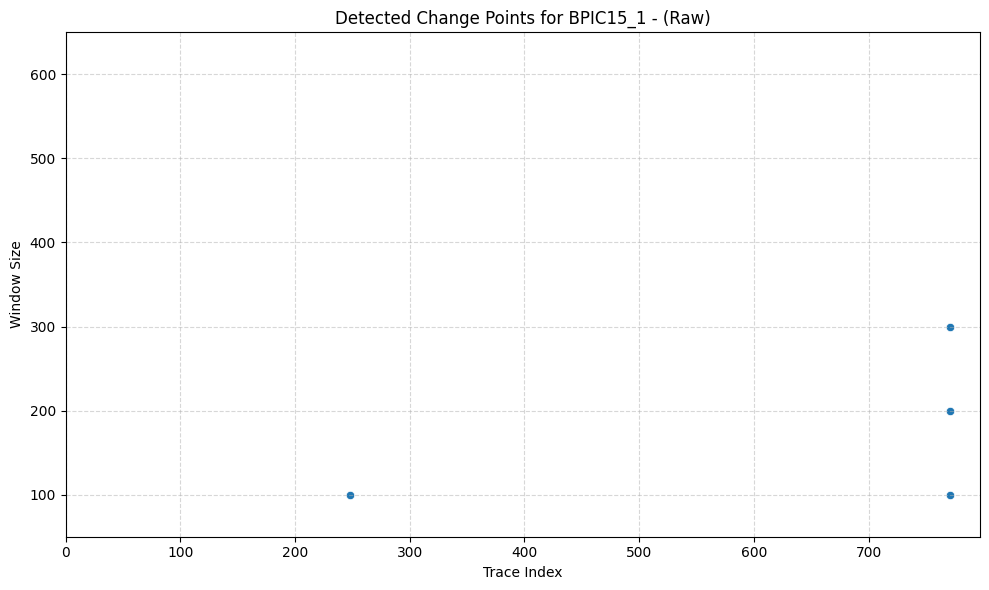

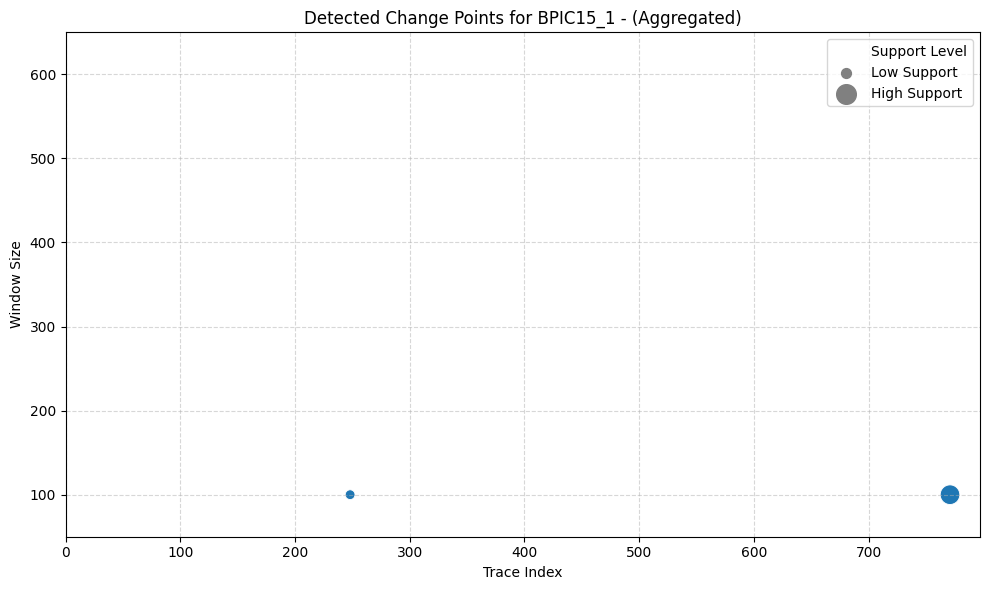

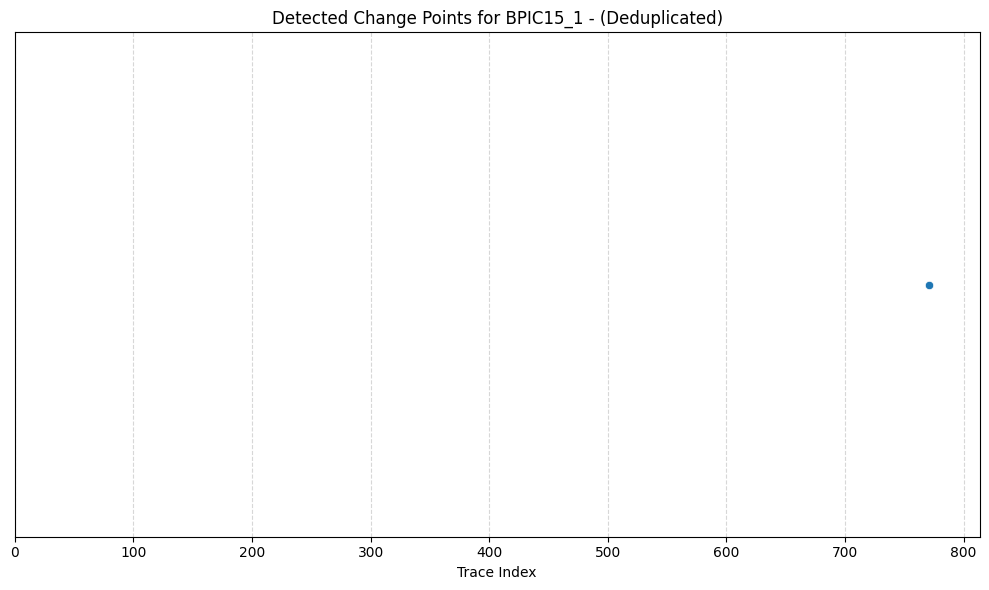

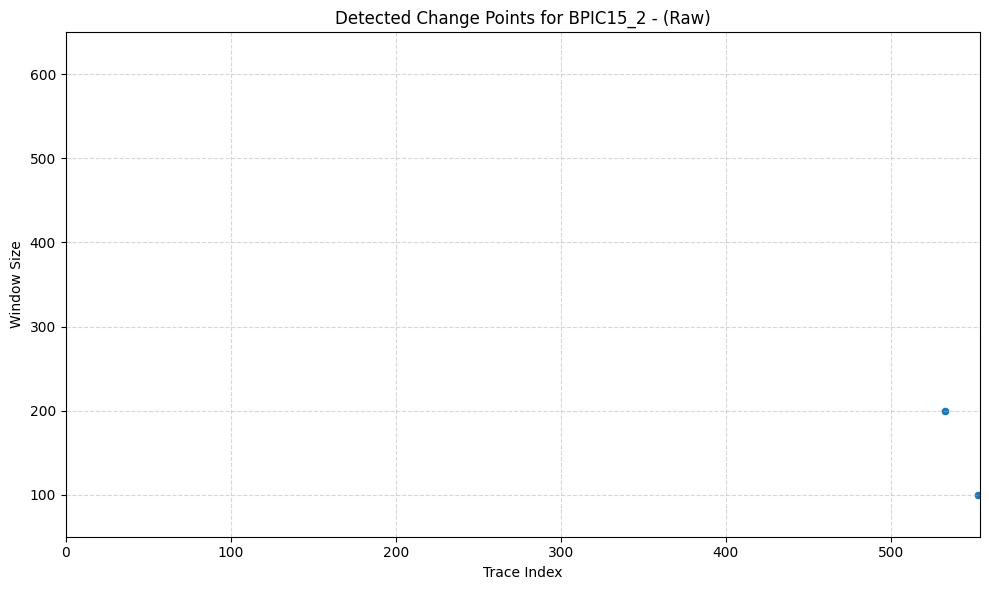

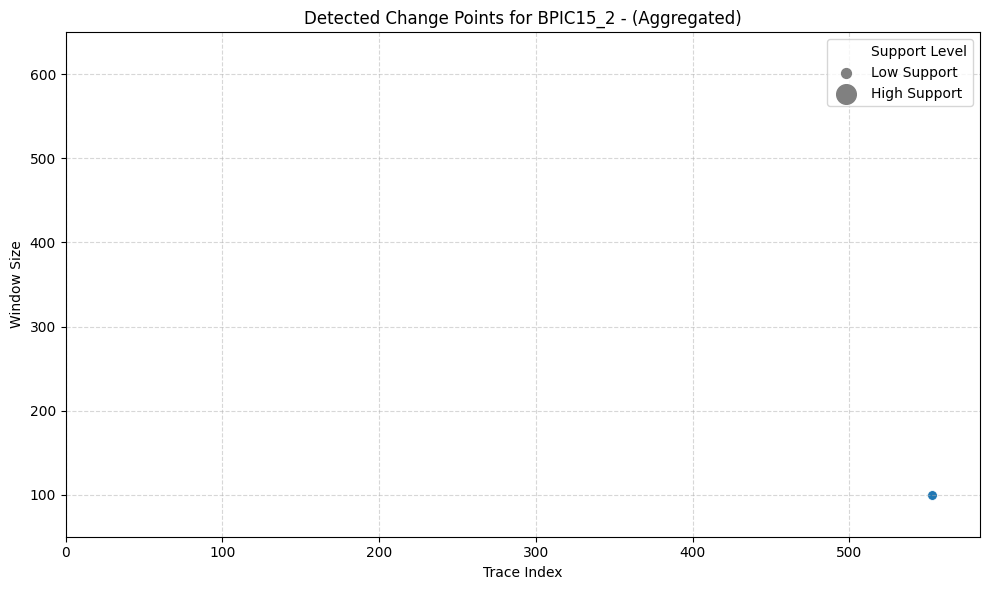

[INFO] No change points to plot for dataset BPIC15_2.


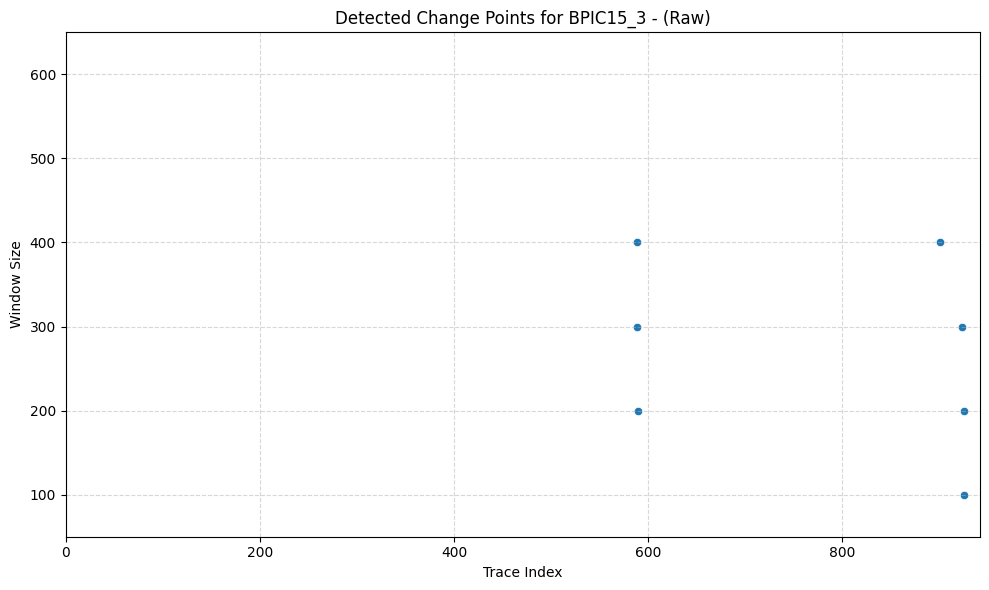

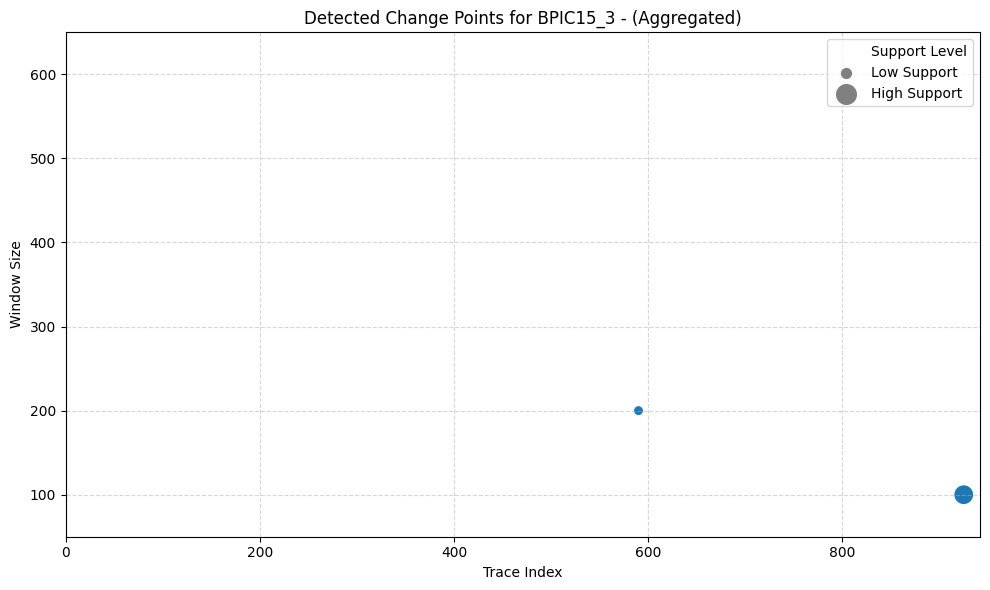

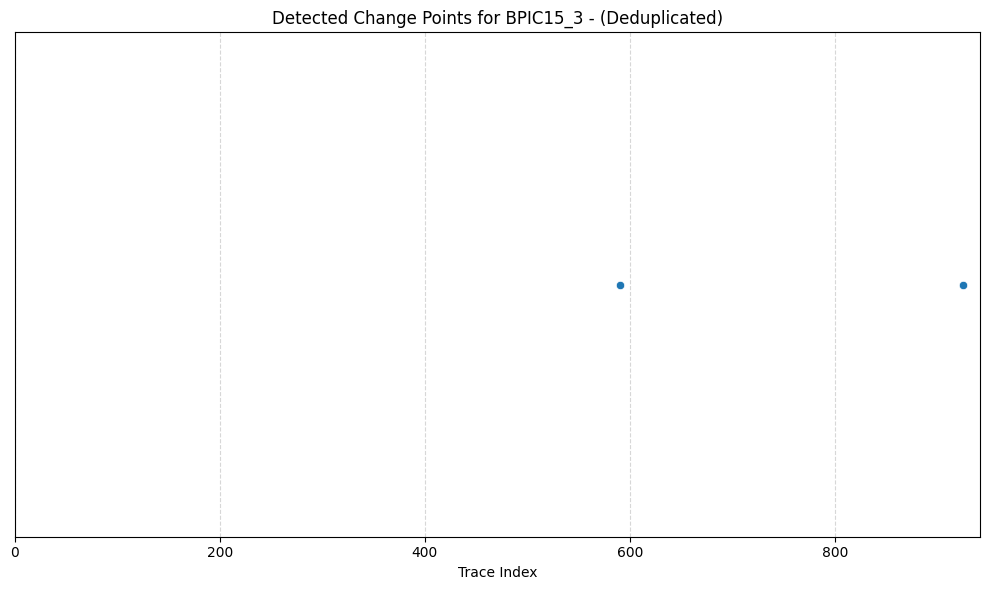

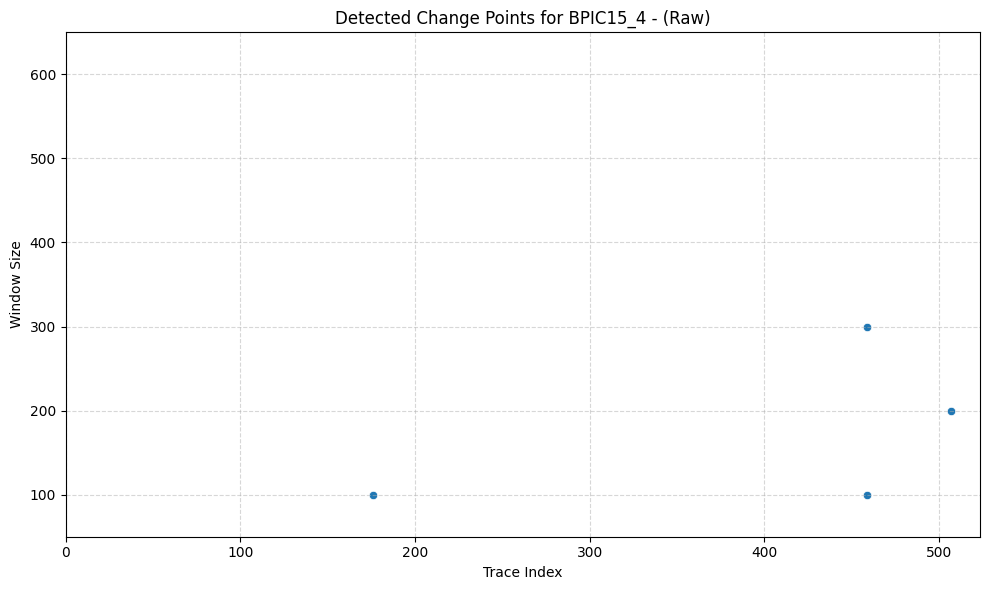

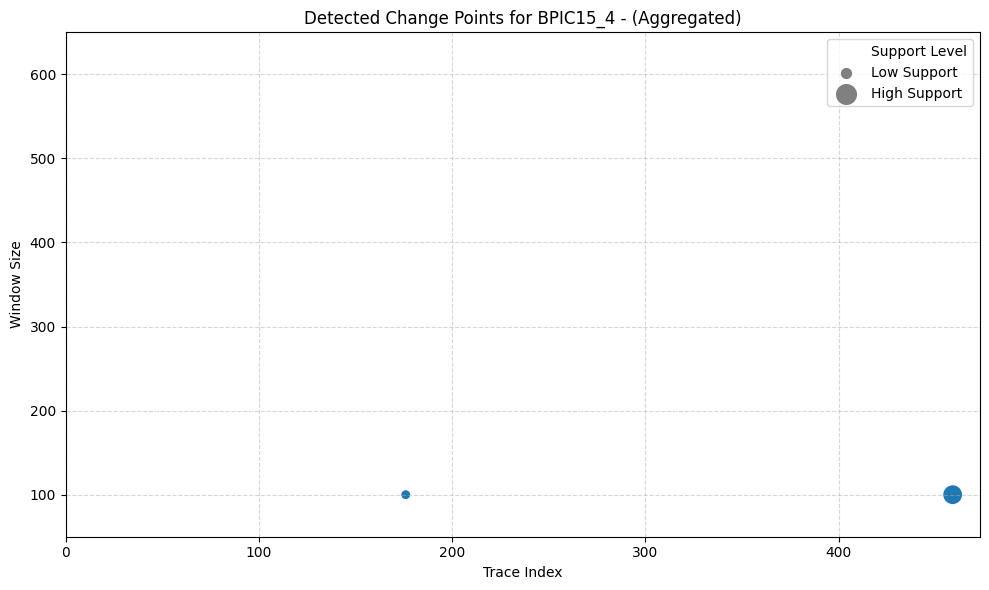

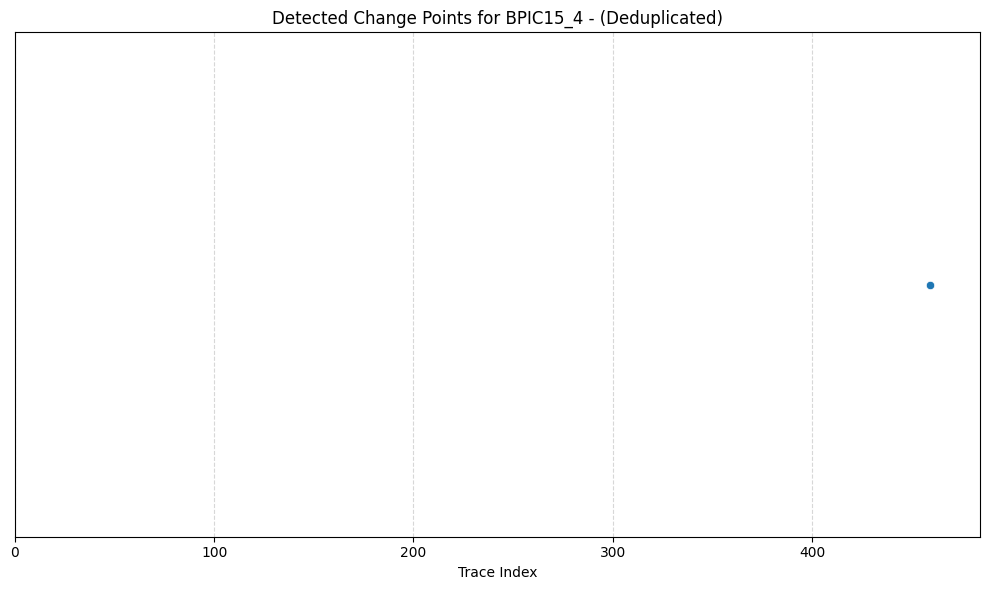

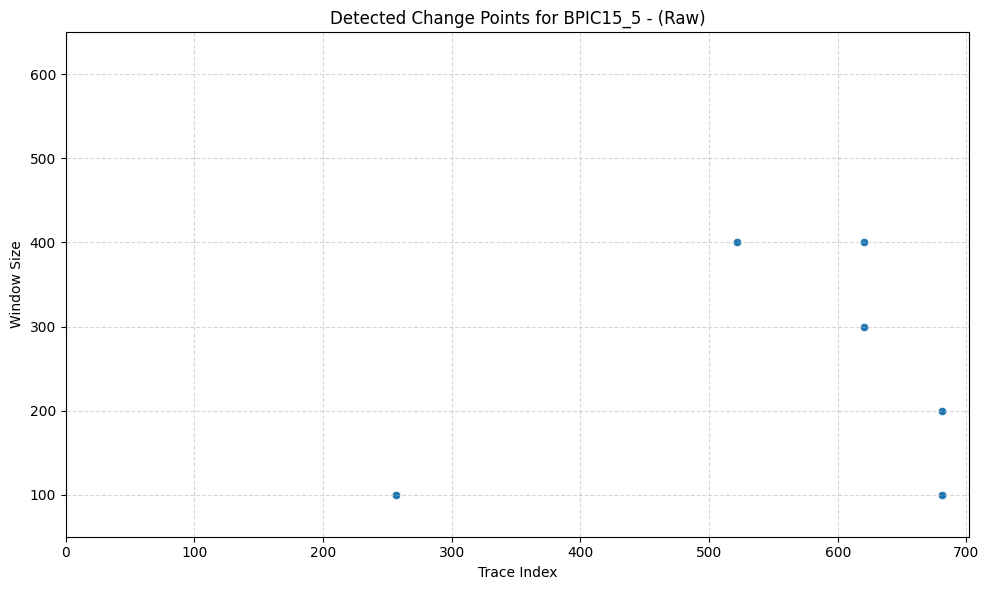

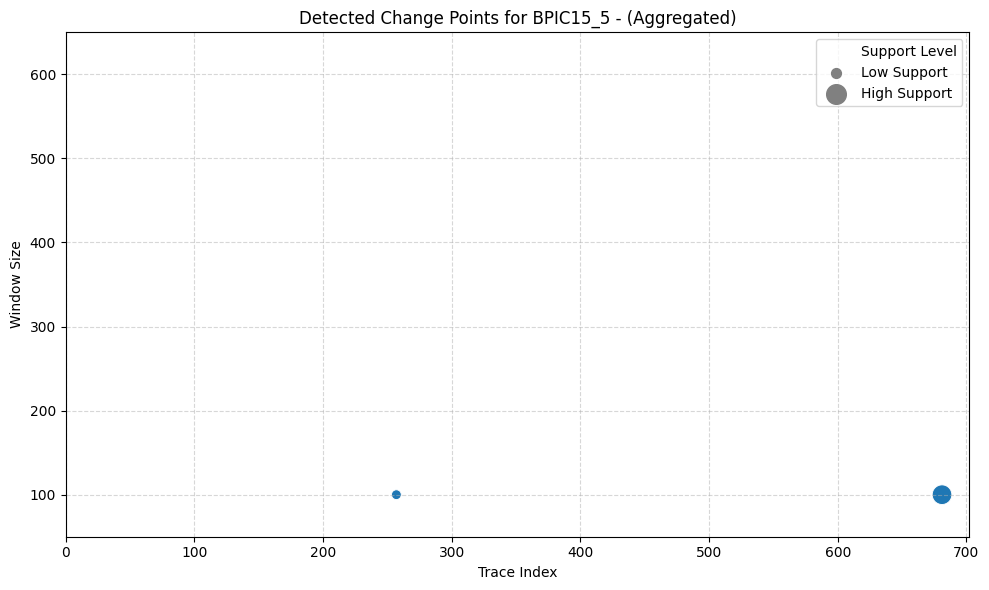

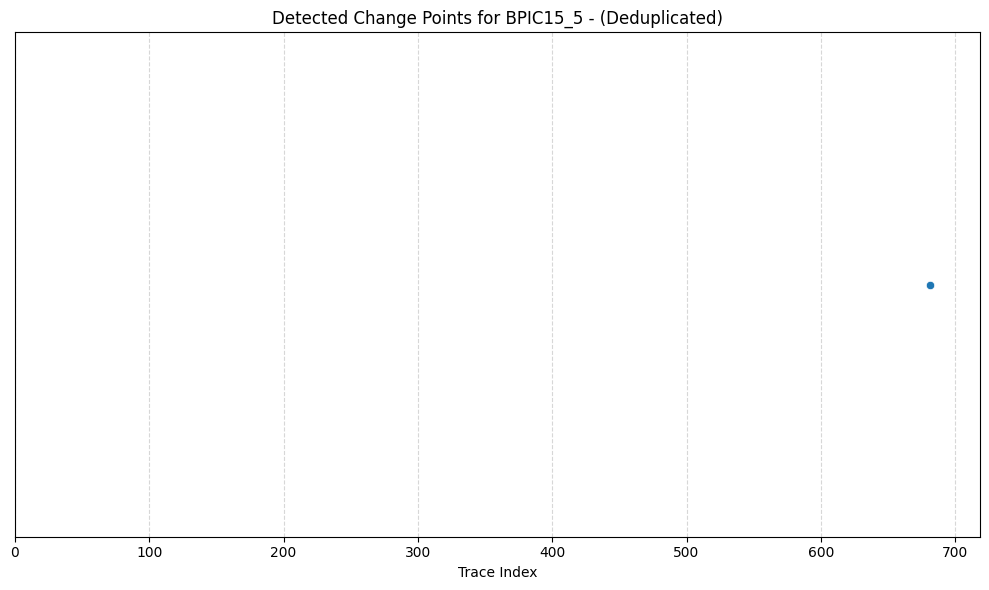

[INFO] No change points to plot for dataset BPIC17.
[INFO] No change points to plot for dataset BPIC17.
[INFO] No change points to plot for dataset BPIC17.
[INFO] No change points to plot for dataset BPIC18.
[INFO] No change points to plot for dataset BPIC18.
[INFO] No change points to plot for dataset BPIC18.
[INFO] No change points to plot for dataset BPIC19.
[INFO] No change points to plot for dataset BPIC19.
[INFO] No change points to plot for dataset BPIC19.


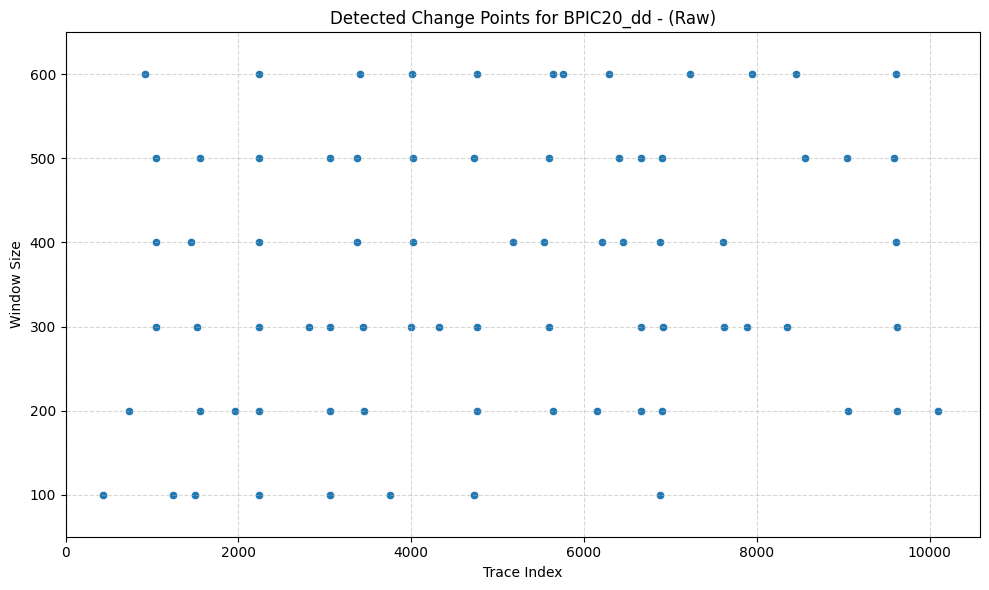

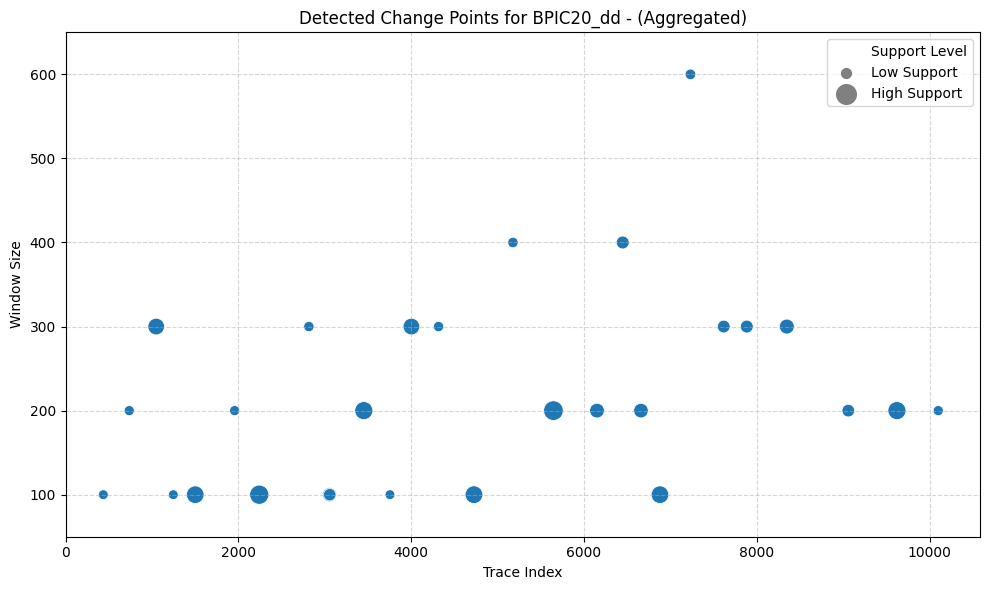

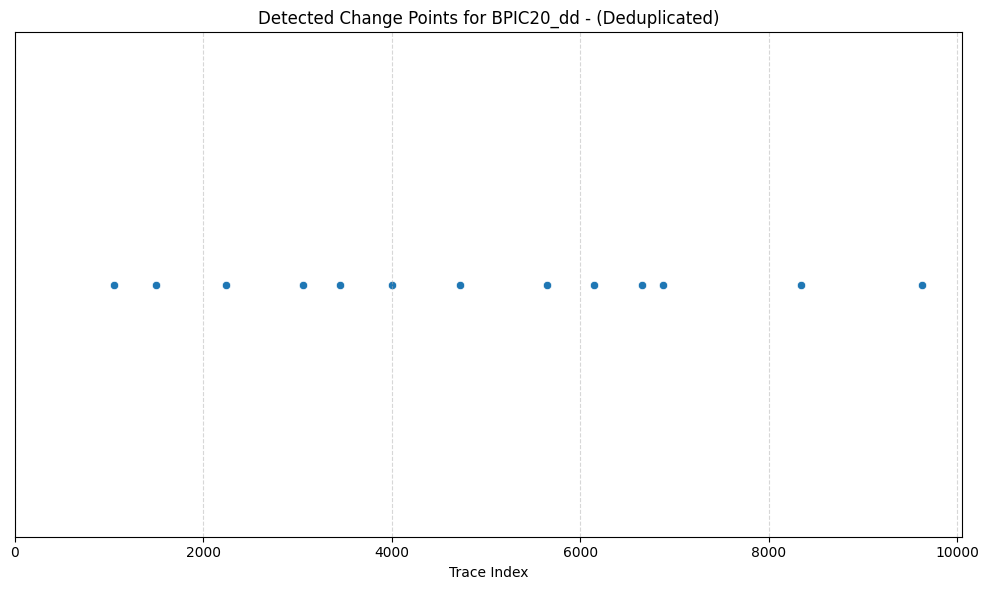

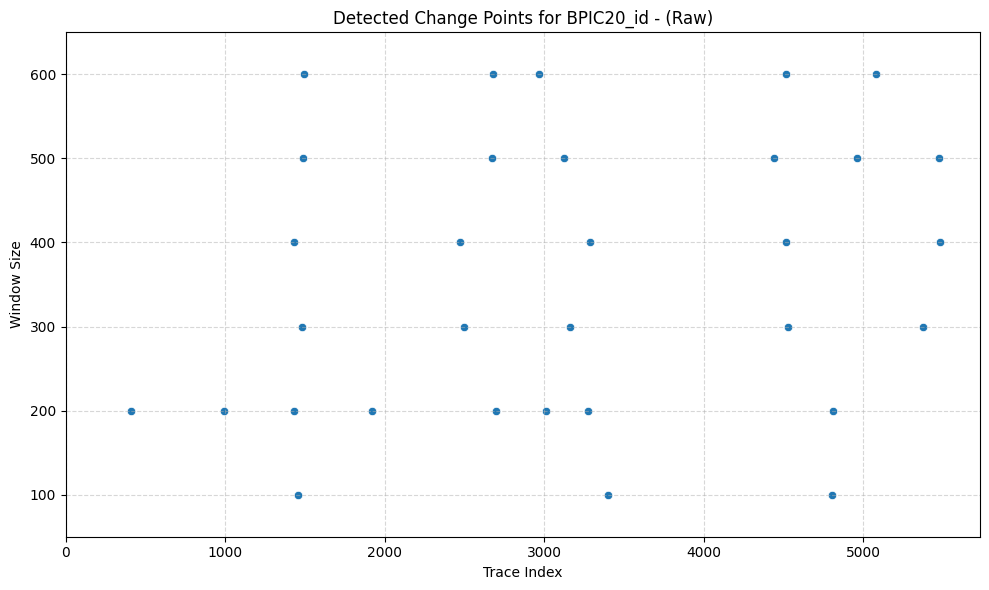

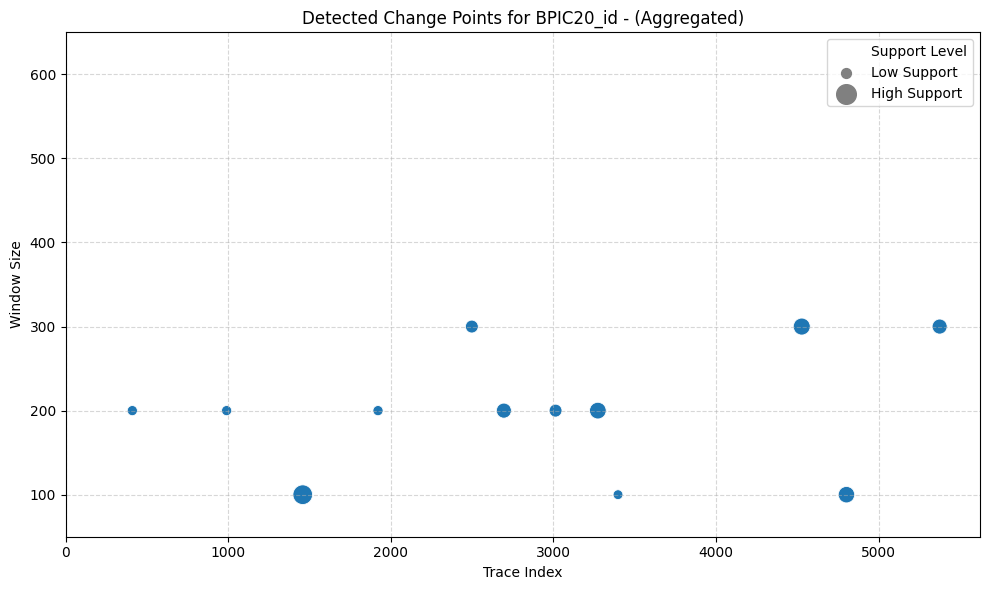

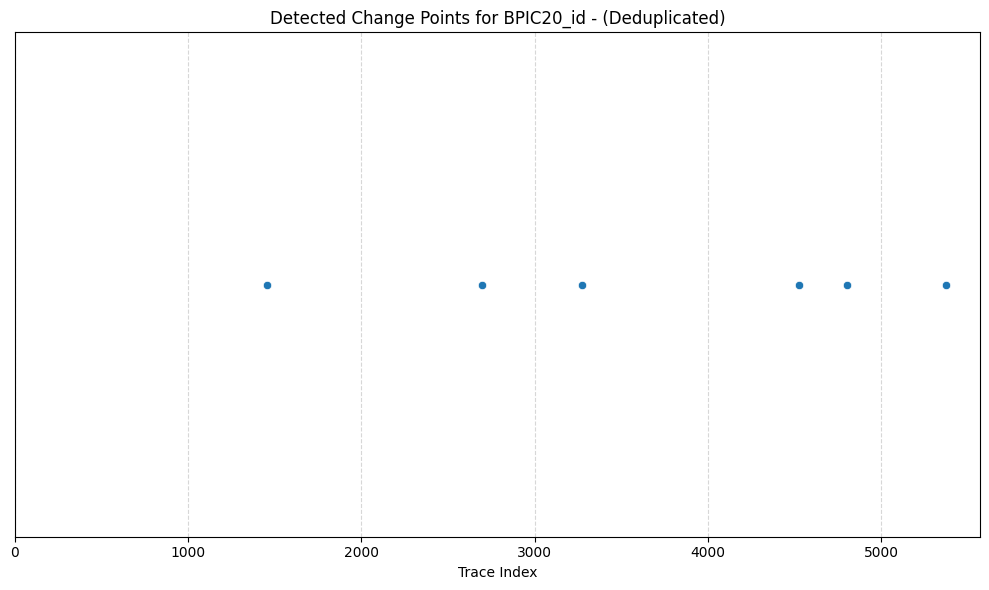

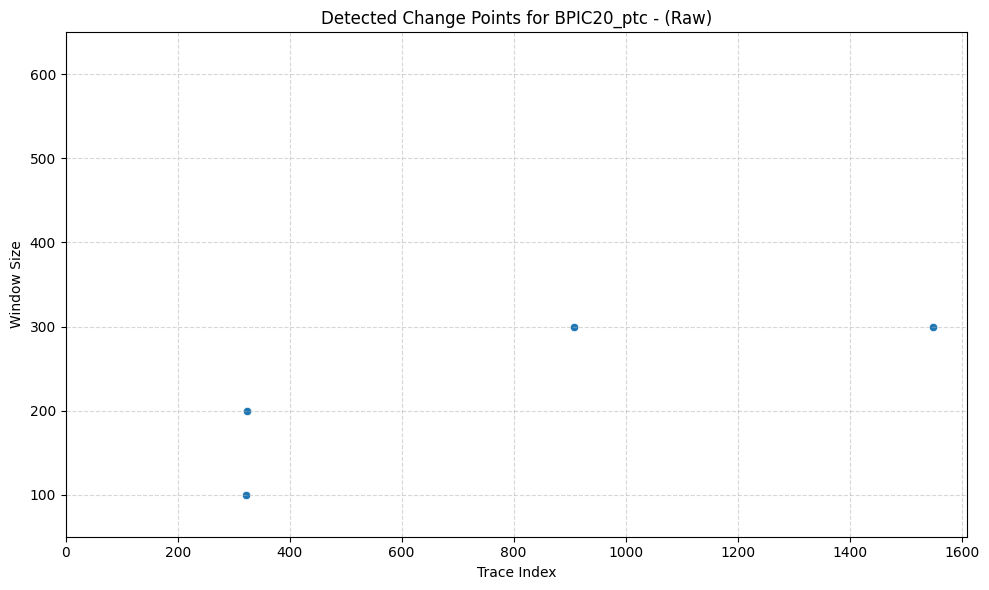

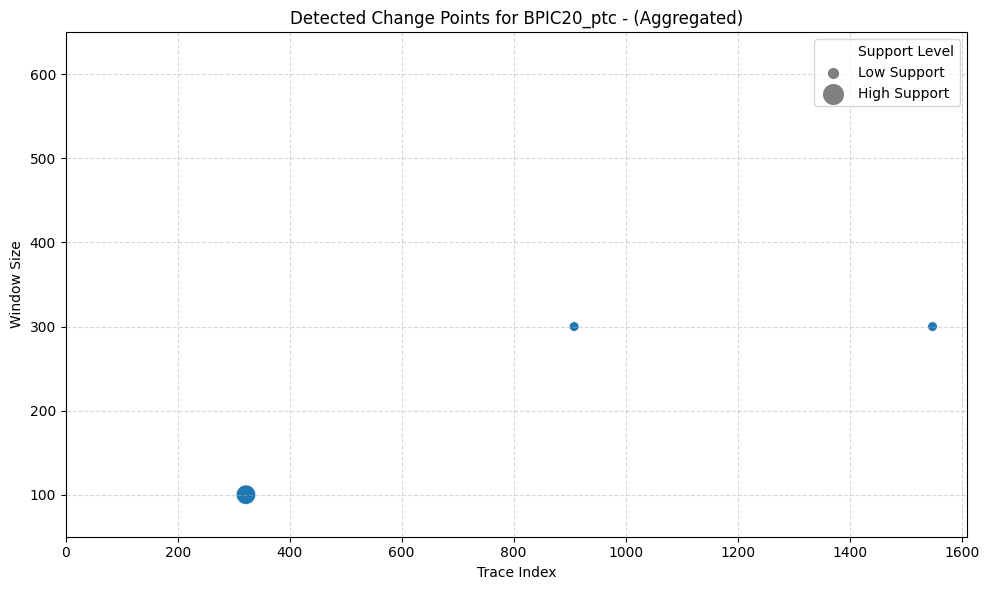

[INFO] No change points to plot for dataset BPIC20_ptc.


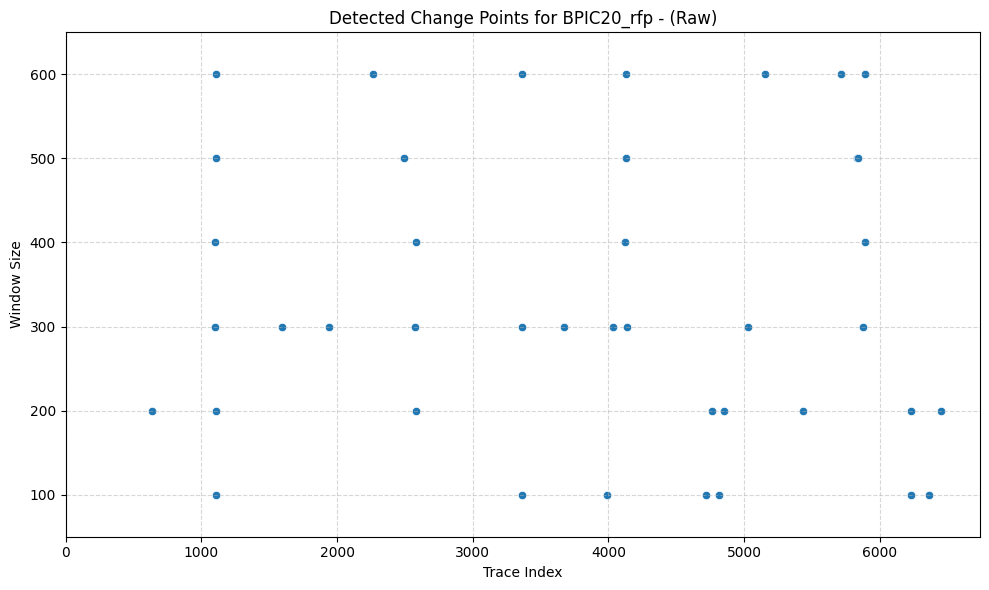

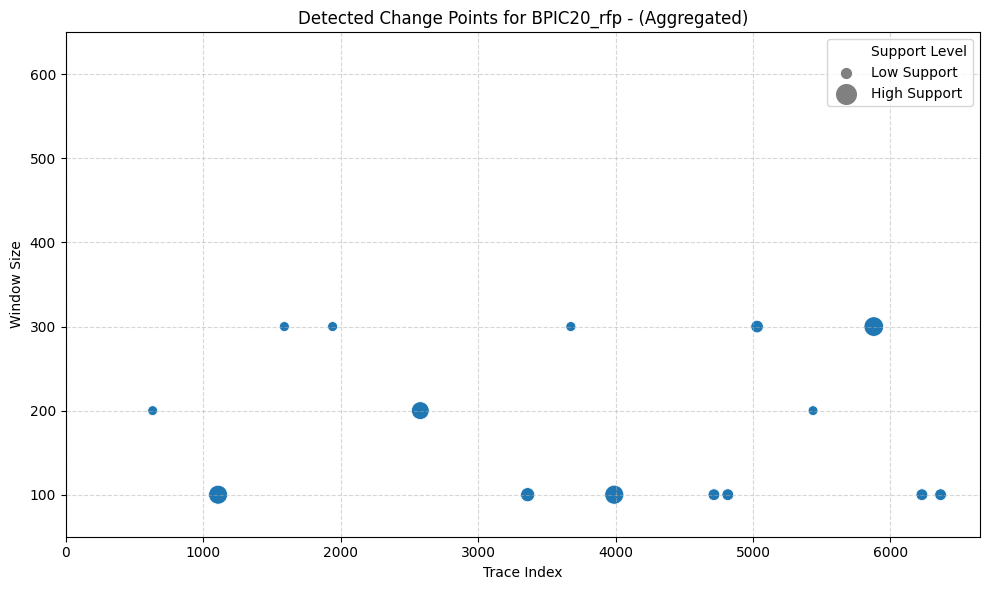

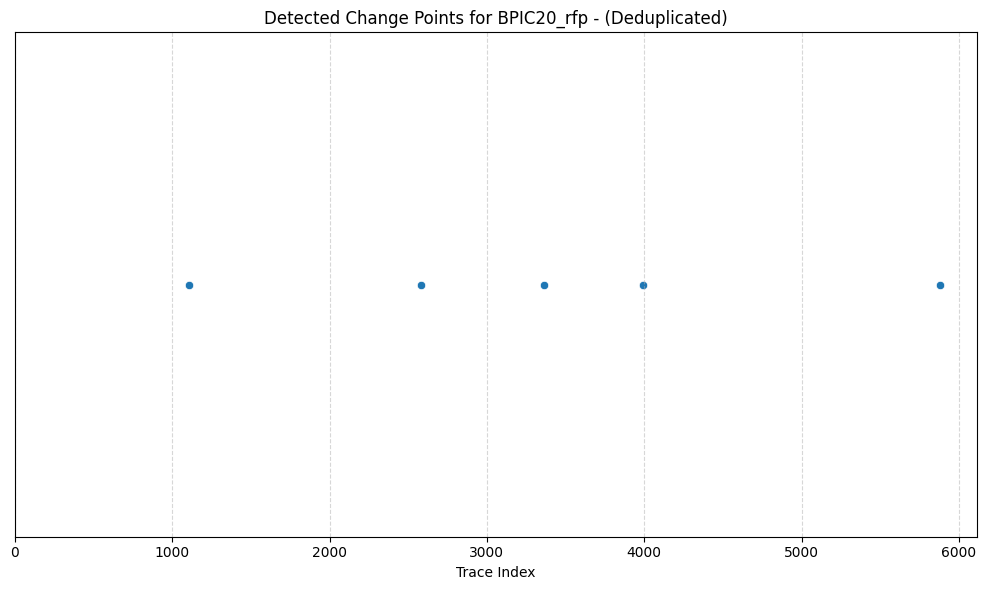

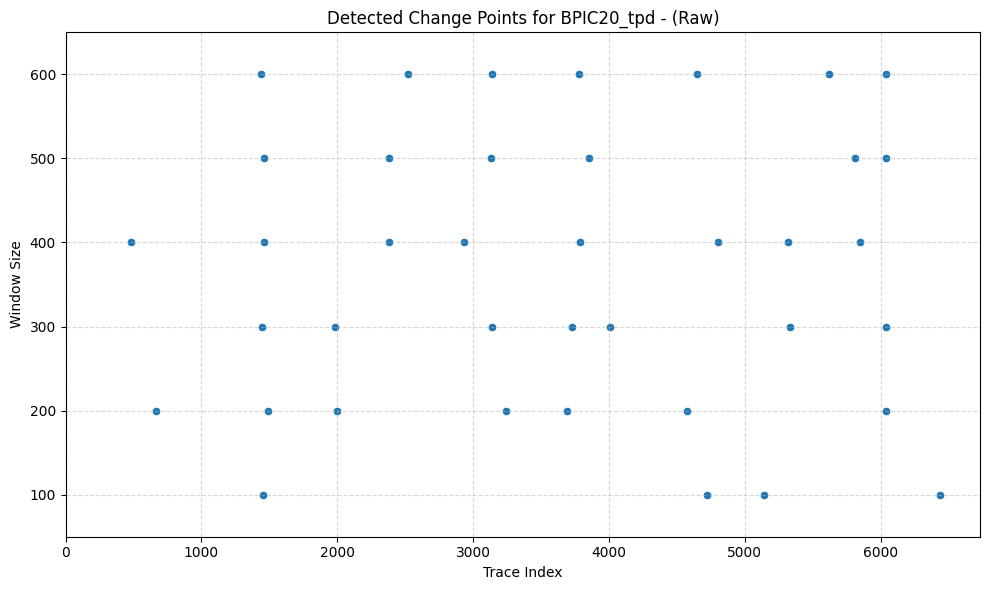

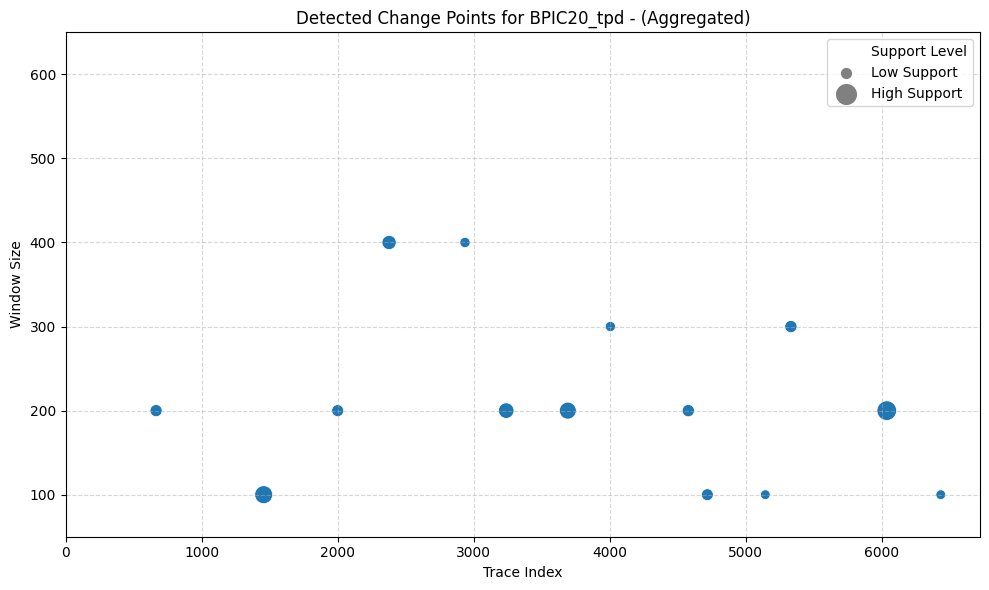

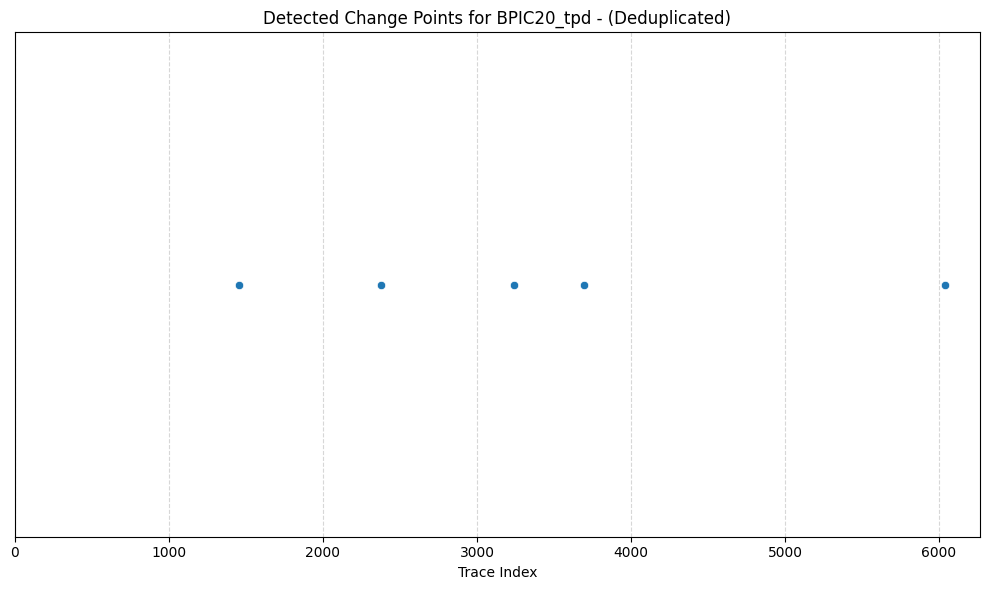

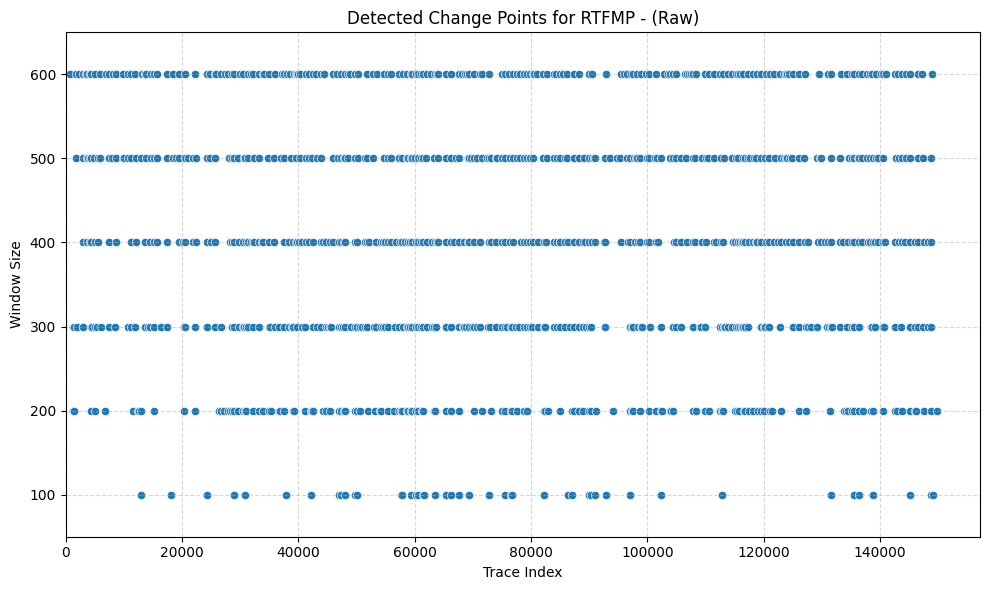

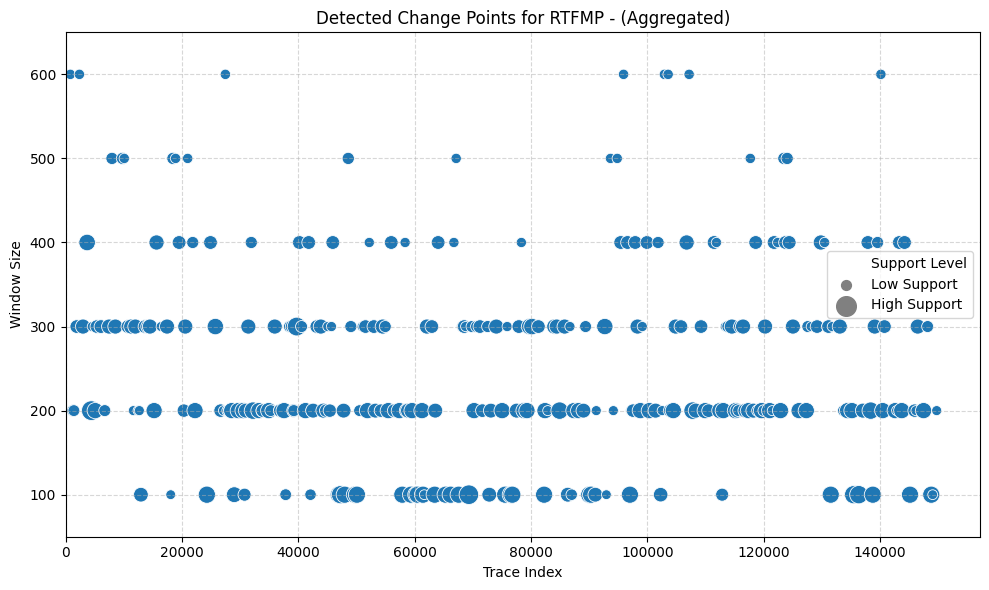

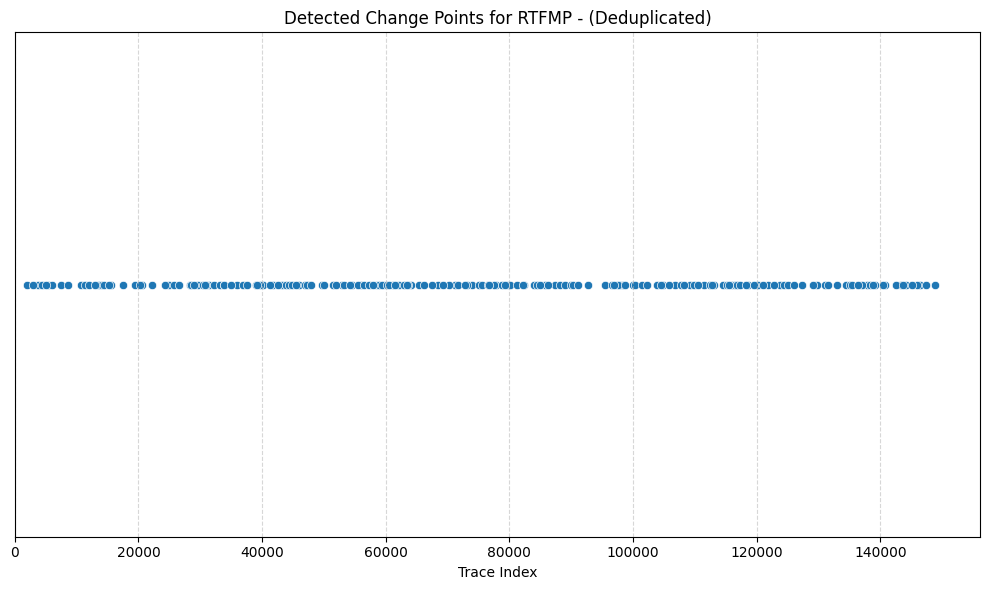

[INFO] No change points to plot for dataset SEPSIS.
[INFO] No change points to plot for dataset SEPSIS.
[INFO] No change points to plot for dataset SEPSIS.


In [39]:
import matplotlib.patches as mpatches


def plot_change_points(dataset, input, input_type, window_sizes, title_suffix=""):
    """
    Plot detected change points for a dataset.

    Parameters
    ----------
    dataset : str
        Name of the dataset (for title).
    input : dict, list, or DataFrame
        Input containing change point information.
    input_type : str
        Must be one of 'list_of_windows', 'list_of_cps', or 'dataframe'.
    window_sizes : list
        List of all window sizes (used for consistent y-ticks).
    title_suffix : str
        Additional string to append to plot title.
    """
    
    # Convert input to DataFrame
    if input_type == 'list_of_windows':
        # Input is {window_size: [cp, cp, ...], ...}
        rows = []
        for ws, cps in input.items():
            for cp in cps:
                rows.append({"cp": cp, "window_size": ws})
        dataset_df = pd.DataFrame(rows)

    elif input_type == 'list_of_cps':
        # Input is [cp1, cp2, ...] – no window size known
        dataset_df = pd.DataFrame({"cp": input})
        dataset_df["window_size"] = 0

    elif input_type == 'dataframe':
        dataset_df = input

    else:
        raise ValueError(f"Invalid input_type '{input_type}'. Must be one of 'list_of_windows', 'list_of_cps', 'dataframe'.")

    if dataset_df.empty:
        print(f"[INFO] No change points to plot for dataset {dataset}.")
        return

    plt.figure(figsize=(10, 6))

    # Check for support info
    use_size = "support" in dataset_df.columns
    min_size, max_size = 50, 200

    if use_size:
        # Normalize support to point sizes
        dataset_df["point_size"] = np.interp(
            dataset_df["support"],
            [dataset_df["support"].min(), dataset_df["support"].max()],
            [min_size, max_size]
        )
        scatter = sns.scatterplot(
            data=dataset_df,
            x="cp",
            y="window_size",
            size="point_size",
            sizes=(min_size, max_size),
            legend=False
        )
    else:
        scatter = sns.scatterplot(
            data=dataset_df,
            x="cp",
            y="window_size",
            legend=False
        )

    plt.title(f"Detected Change Points for {dataset}{' - ' + title_suffix if title_suffix else ''}")
    plt.xlabel("Trace Index")

    if input_type != 'list_of_cps':
        plt.ylabel("Window Size")
        plt.yticks(sorted(window_sizes))
        plt.ylim(top=max(window_sizes) + 50, bottom=min(window_sizes) - 50)
    else:
        plt.ylabel("")  # No y-axis (flat line)
        plt.yticks([])

    plt.xlim(left=0)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Create a manual legend for support (if available)
    if use_size:
        min_patch = plt.scatter([], [], s=min_size, color='gray', label=f"Low Support")
        max_patch = plt.scatter([], [], s=max_size, color='gray', label=f"High Support")

        legend_elements = [
            mpatches.Patch(color='none', label='Support Level'),
            min_patch, max_patch
        ]
        plt.legend(handles=legend_elements, title=None, frameon=True)

    plt.tight_layout()
    plt.show()

# Plot original and deduplicated points
for dataset, df in change_points_dict.items():
    plot_change_points(dataset, change_points_dict[dataset], input_type='list_of_windows', window_sizes=window_sizes, title_suffix="(Raw)")
    plot_change_points(dataset, aggregated_cp_dict[dataset], input_type='dataframe', window_sizes=window_sizes, title_suffix="(Aggregated)")
    plot_change_points(dataset, deduplicated_cp_dict[dataset], input_type='list_of_cps', window_sizes=window_sizes, title_suffix="(Deduplicated)")

In [3]:
import pandas as pd

# Read both CSV files
df1 = pd.read_csv("cdrift-evaluation/algorithm_results.csv")
df2 = pd.read_csv("cdrift-evaluation/algorithm_results_original.csv")

# Combine rows, aligning columns by name
merged_df = pd.concat([df1, df2], ignore_index=True)

# Save to new CSV
merged_df.to_csv("cdrift-evaluation/merged_results.csv", index=False)